✅ Top 10 Recommended Influencers per Platform


platform,creator_id,success_prob,avg_eng_rate,activity_score,avg_age_18_24,avg_age_25_34,avg_female_ratio
instagram,unknown_creator,0.04742587317756678,0.0,0.0,0.0,0.0,0.0
tiktok,unknown_creator,0.04742587317756678,0.0,0.0,0.0,0.0,0.0
twitter,unknown_creator,0.04742587317756678,0.0,0.0,0.0,0.0,0.0
youtube,unknown_creator,0.04742587317756678,0.0,0.0,0.0,0.0,0.0


/databricks/python/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/databricks/python/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


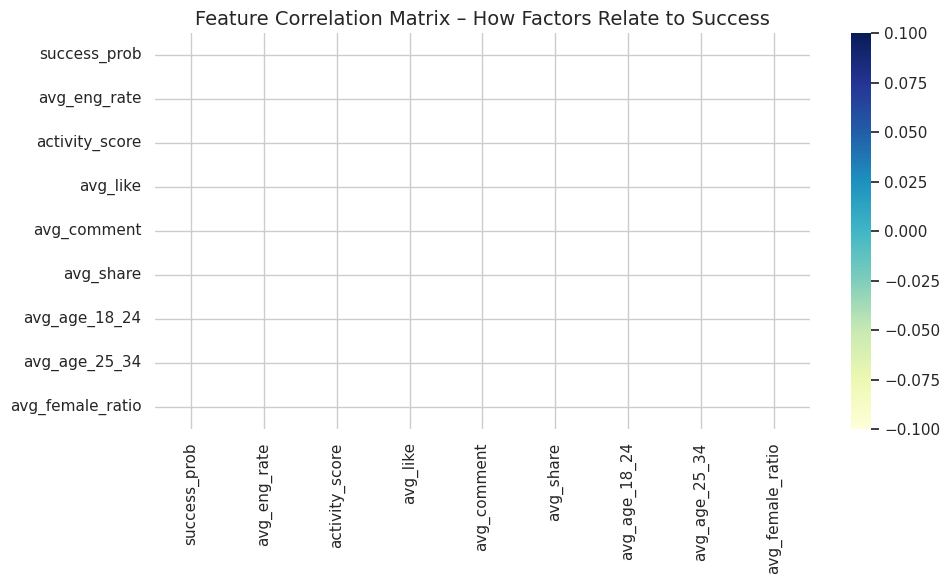

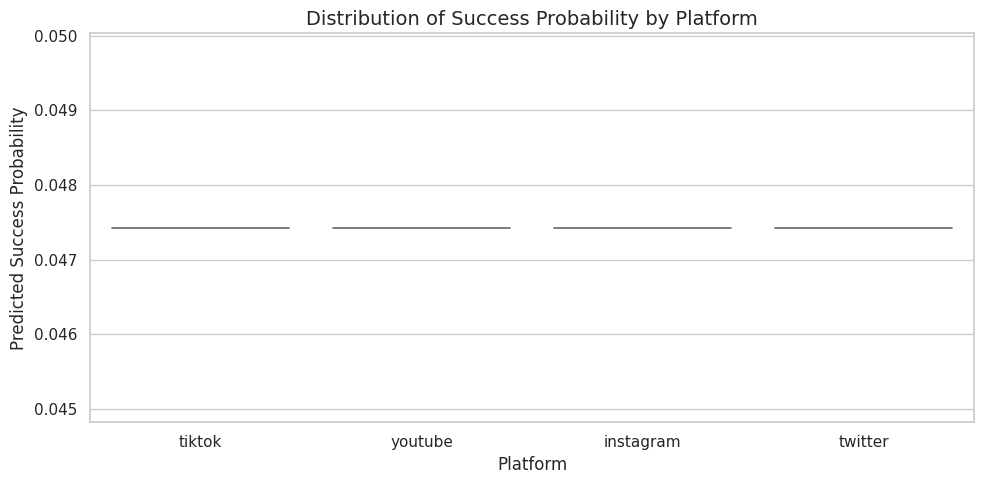

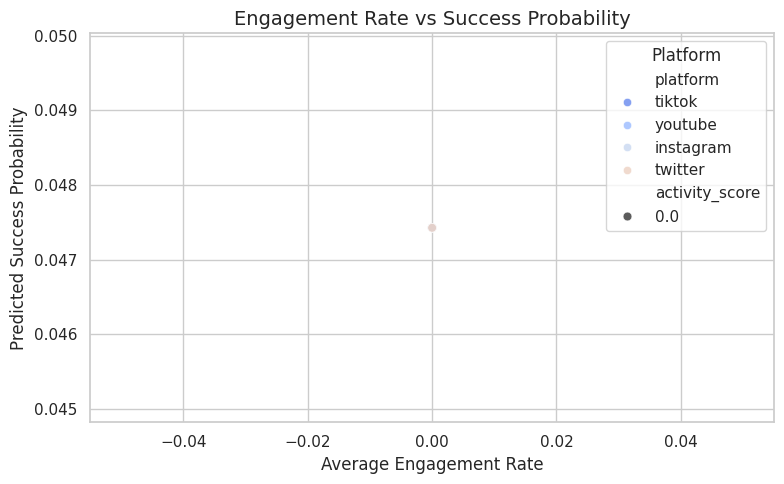

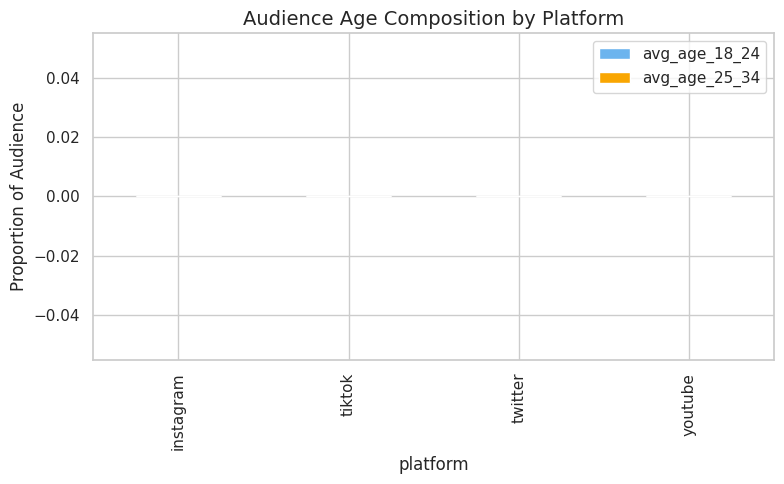

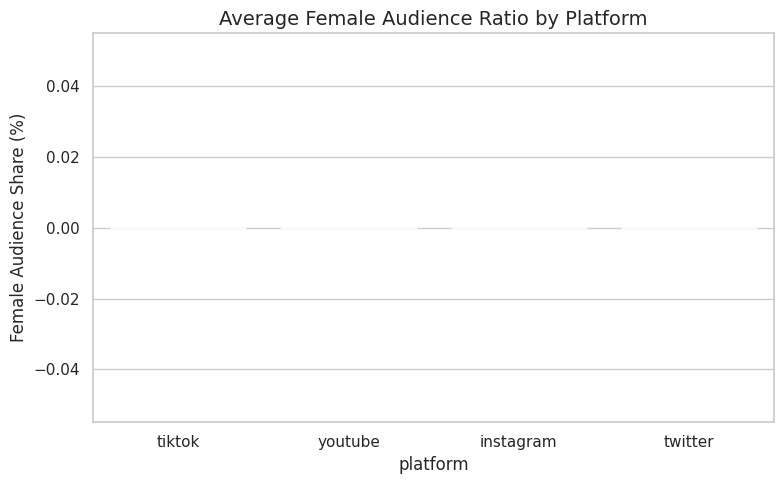

/home/spark-93af7cbc-b51c-49af-9c5d-d9/.ipykernel/2476/command-7463631931467030-3432504343:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="success_prob", x=top_global.index, data=top_global, orient="h", palette="mako")


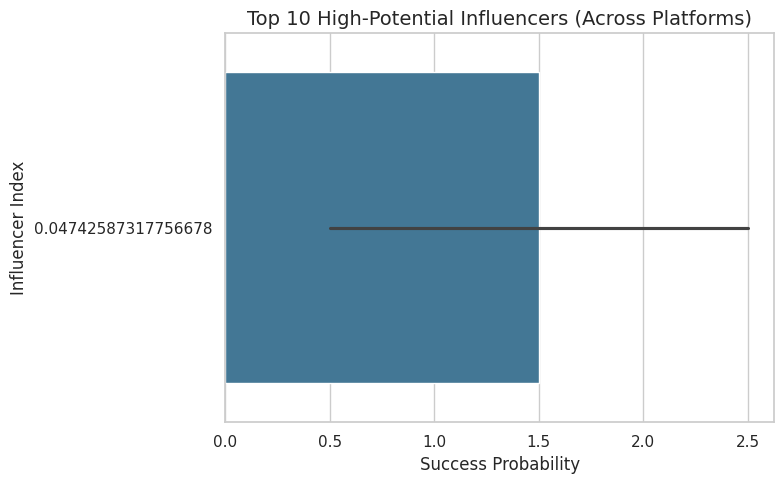

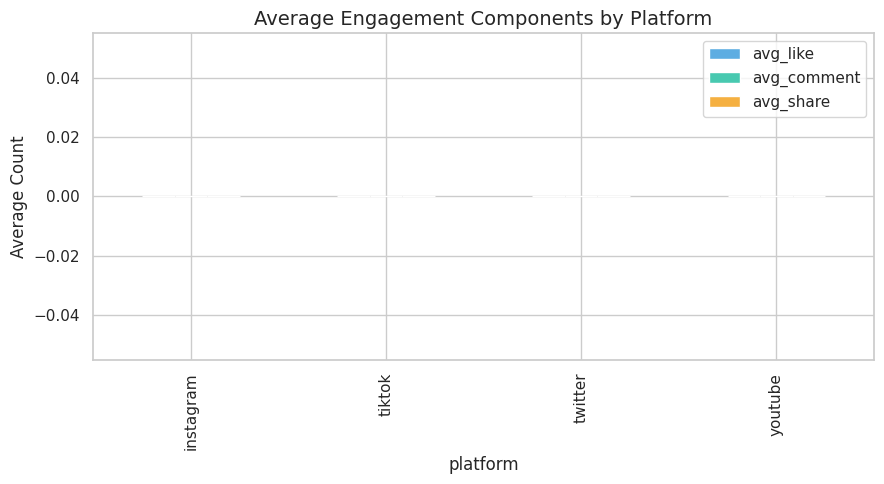

In [0]:
# MAGIC %run ./00_config
# STEP 5: Enhanced Recommendations + Insightful Visualizations

from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Setup ----
sns.set(style="whitegrid", palette="coolwarm")
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

try:
    tbl  # type: ignore
except NameError:
    CATALOG = "influencer"
    def tbl(name: str) -> str:
        return f"{CATALOG}.{name}"

features_tbl = tbl("ml.creator_features")
pred_tbl = tbl("ml.creator_predictions")

if not (spark.catalog.tableExists(features_tbl) and spark.catalog.tableExists(pred_tbl)):
    raise RuntimeError("❌ Missing tables. Please run Steps 3 & 4 first.")

features = spark.table(features_tbl)
preds = spark.table(pred_tbl)

# ---- Join features + predictions ----
joined = (
    features.join(preds, on="creator_norm_id", how="inner")
    .withColumn("rank", F.rank().over(Window.partitionBy("platform").orderBy(F.desc("success_prob"))))
)

# ---- Top 10 influencers per platform ----
top10 = joined.filter("rank <= 10").select(
    "platform", "creator_id", "success_prob", "avg_eng_rate", "activity_score",
    "avg_age_18_24", "avg_age_25_34", "avg_female_ratio"
)

print("✅ Top 10 Recommended Influencers per Platform")
display(top10.orderBy("platform", F.desc("success_prob")))

# ---- Convert to Pandas ----
pdf = joined.select(
    "platform", "success_prob", "avg_eng_rate", "activity_score",
    "avg_like", "avg_comment", "avg_share",
    "avg_age_18_24", "avg_age_25_34", "avg_female_ratio"
).toPandas()

# ------------------------------------------------------------------
# 1️⃣ Correlation Heatmap – Feature Relationships
# ------------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(pdf.corr(numeric_only=True), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Feature Correlation Matrix – How Factors Relate to Success")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 2️⃣ Platform-wise Success Probability Distribution
# ------------------------------------------------------------------
plt.figure(figsize=(10, 5))
sns.violinplot(x="platform", y="success_prob", data=pdf, inner="quartile", linewidth=1.2)
plt.title("Distribution of Success Probability by Platform")
plt.xlabel("Platform")
plt.ylabel("Predicted Success Probability")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 3️⃣ Engagement Rate vs Success Probability
# ------------------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x="avg_eng_rate", y="success_prob", hue="platform", size="activity_score",
    data=pdf, alpha=0.8, sizes=(40, 200)
)
plt.title("Engagement Rate vs Success Probability")
plt.xlabel("Average Engagement Rate")
plt.ylabel("Predicted Success Probability")
plt.legend(title="Platform")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 4️⃣ Audience Demographics (Stacked Bars)
# ------------------------------------------------------------------
age_df = pdf.groupby("platform")[["avg_age_18_24", "avg_age_25_34"]].mean().reset_index()
age_df.plot(
    x="platform", kind="bar", stacked=True, color=["#6CB4EE", "#F9A602"], figsize=(8, 5)
)
plt.title("Audience Age Composition by Platform")
plt.ylabel("Proportion of Audience")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 5️⃣ Gender Ratio Analysis – Female Audience Share
# ------------------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.barplot(x="platform", y="avg_female_ratio", data=pdf, hue="platform", dodge=False)
plt.title("Average Female Audience Ratio by Platform")
plt.ylabel("Female Audience Share (%)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 6️⃣ Top 10 Influencers (Global) – Success Probability
# ------------------------------------------------------------------
top_global = (
    pdf.sort_values("success_prob", ascending=False)
    .head(10)
    .sort_values("success_prob")
)
plt.figure(figsize=(8, 5))
sns.barplot(y="success_prob", x=top_global.index, data=top_global, orient="h", palette="mako")
plt.title("Top 10 High-Potential Influencers (Across Platforms)")
plt.xlabel("Success Probability")
plt.ylabel("Influencer Index")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 7️⃣ Engagement Components – Likes, Comments, Shares (Averages)
# ------------------------------------------------------------------
eng_df = (
    pdf.groupby("platform")[["avg_like", "avg_comment", "avg_share"]].mean().reset_index()
)
eng_df.plot(
    x="platform", kind="bar", figsize=(9, 5),
    color=["#5DADE2", "#48C9B0", "#F5B041"]
)
plt.title("Average Engagement Components by Platform")
plt.ylabel("Average Count")
plt.tight_layout()
plt.show()
